# **Names and IDs**
 1. Assaf Attias 308214899
 2. Omer Shlomo 204429278

# **1.Loading the data**

Load the data set into pandas data frame

In [ ]:
import pandas as pd
import time

# load
start_run = time.time()
df = pd.read_csv("ex3_data.csv")

## Data Exploration

Explore the data set and the features in it (Count, values, Distribution) to understand it and use the information for implementation decisions.

== Data =========================
             count        mean         std        min         25%         50%         75%          max
NEWSITEID   8281.0   55.820674   29.743937   1.000000   32.000000   58.000000   81.000000   102.000000
RISK10YRS   8746.0   20.143798   10.843465   1.863811   12.051891   17.821904   25.762838    81.187680
SBP         8746.0  139.704894   15.623359  72.000000  130.000000  138.000000  149.000000   231.000000
DBP         8746.0   78.149325   11.988268  40.000000   70.000000   78.000000   86.000000   134.000000
N_AGENTS    8746.0    1.837754    1.035492   0.000000    1.000000    2.000000    3.000000     6.000000
SMOKE_3CAT  8746.0    1.695632    0.693989   1.000000    1.000000    2.000000    2.000000     3.000000
EGFR        8746.0   71.689646   20.684404  14.660000   57.980000   71.310000   84.720000   186.190000
SCREAT      8746.0    1.077442    0.342435   0.420000    0.860000    1.010000    1.210000     4.040000
AGE         8746.0   67.893666    9.432

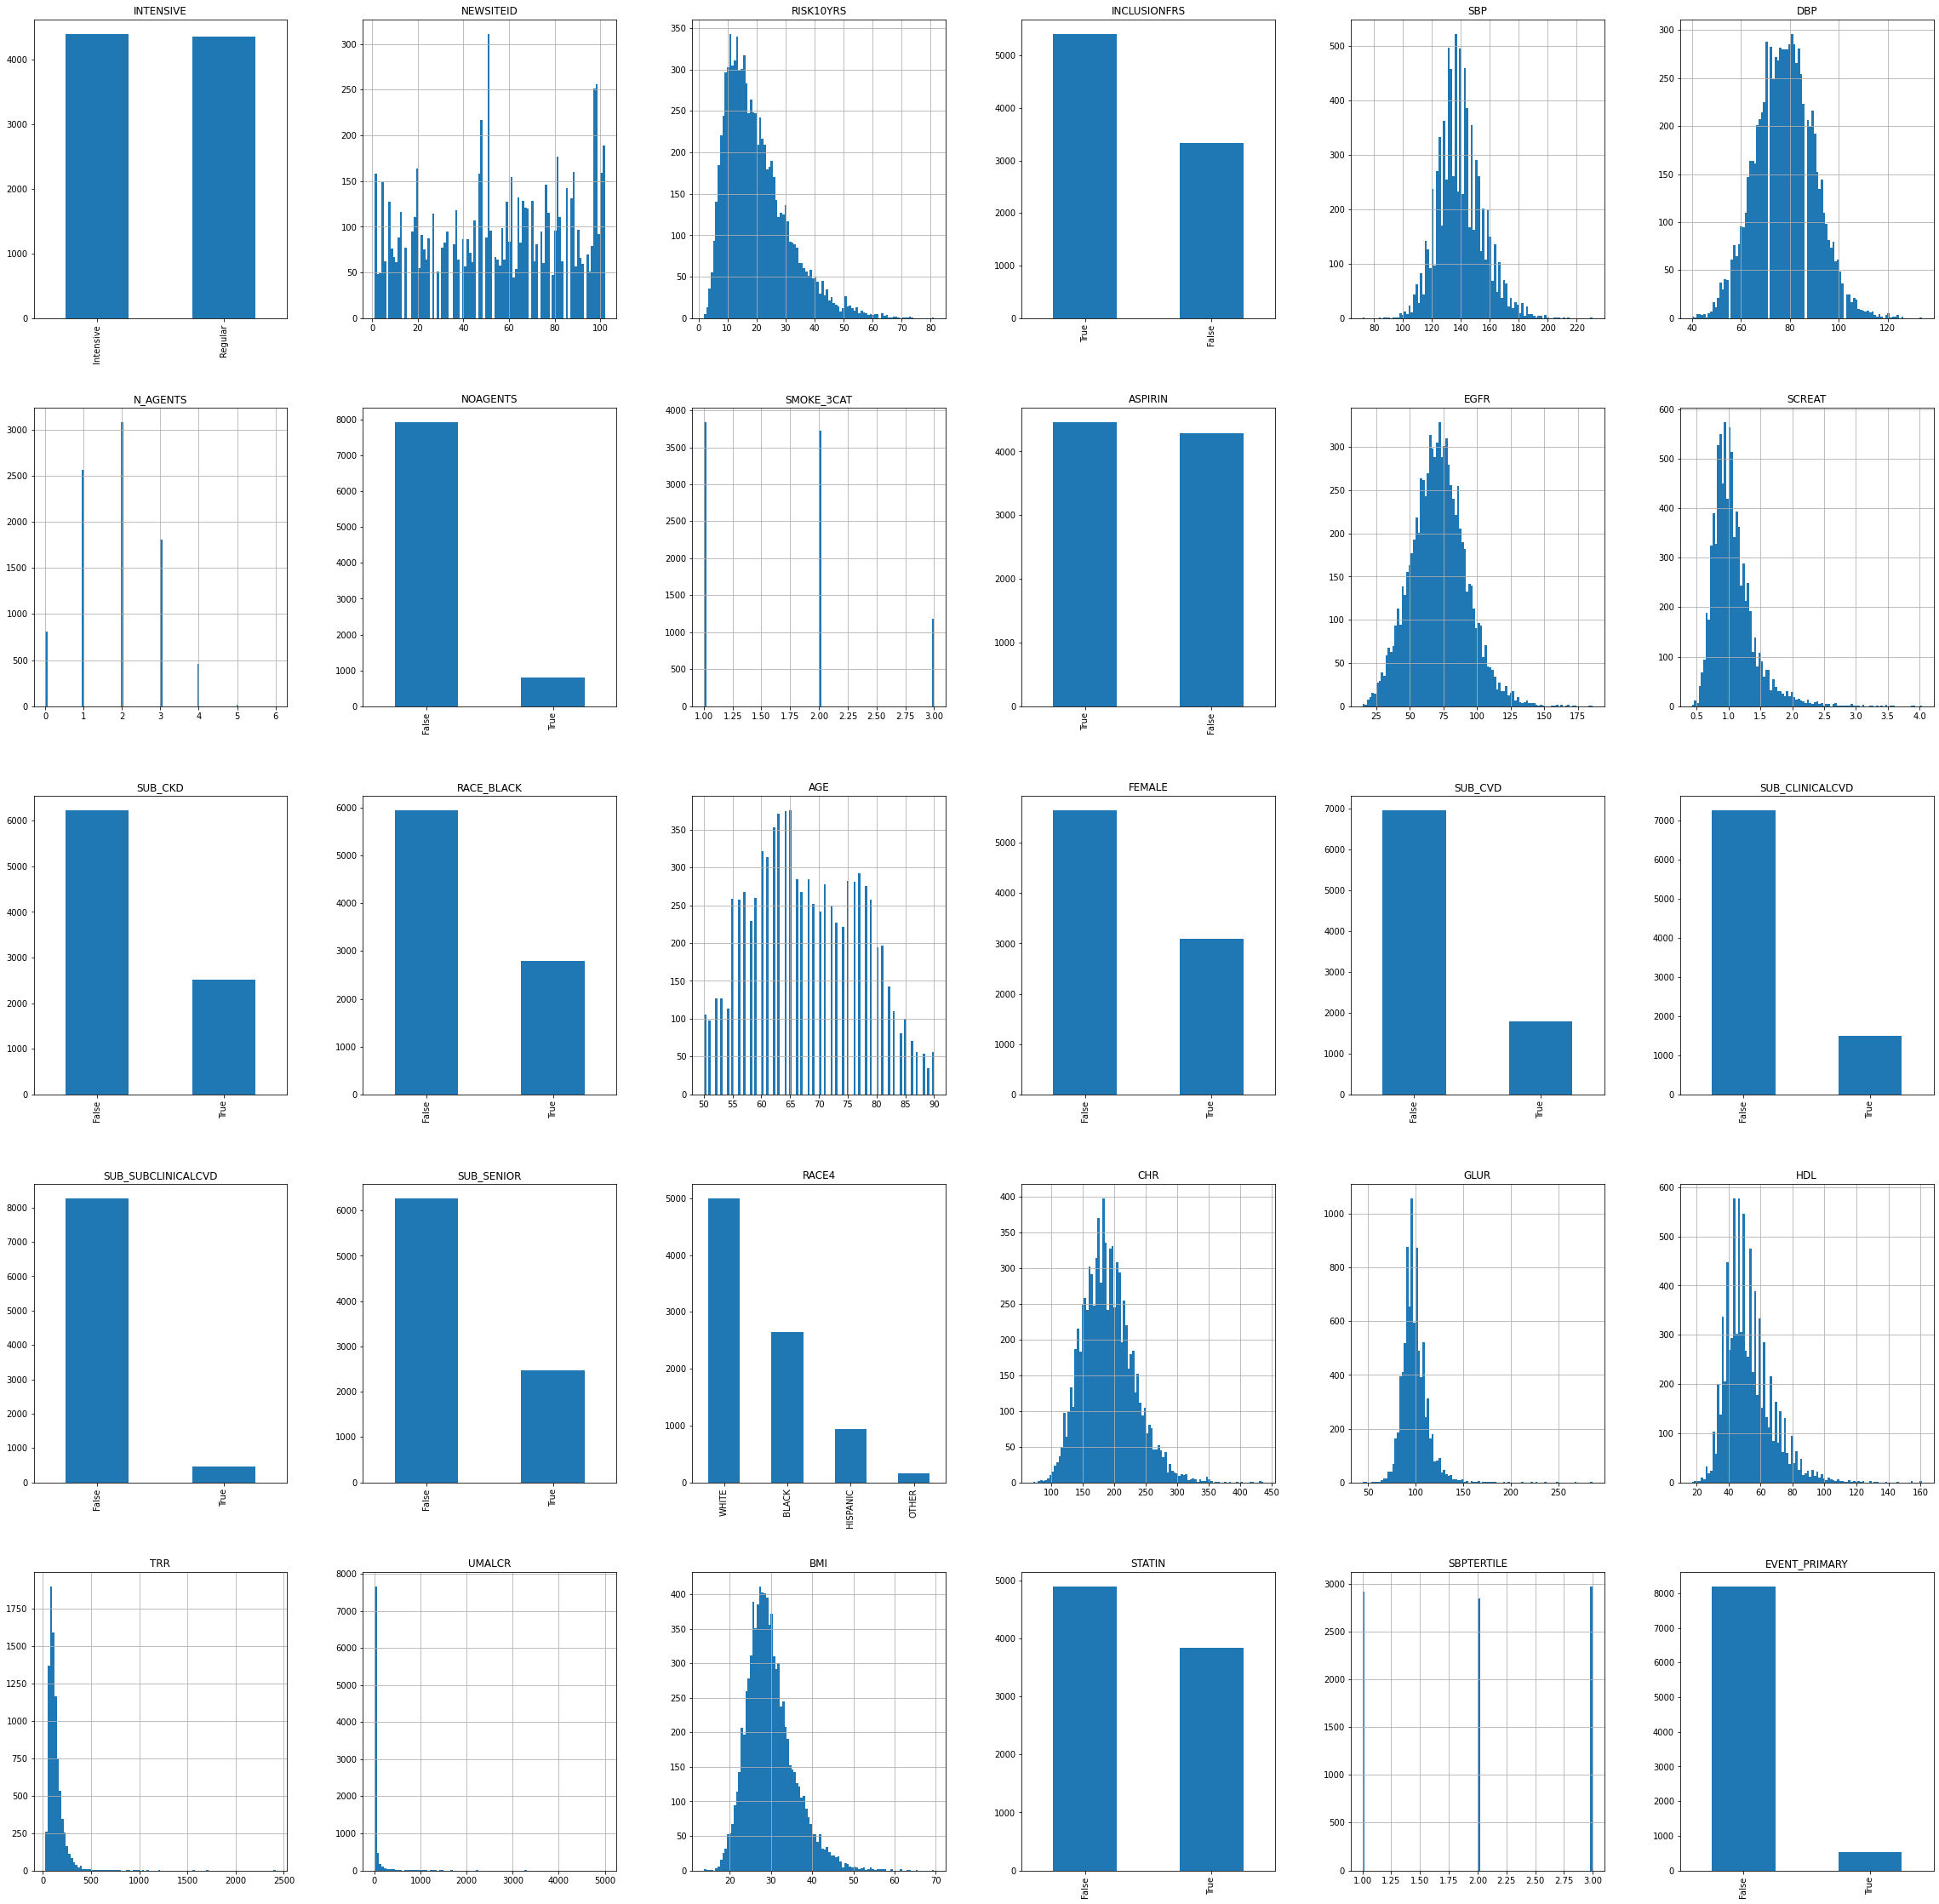

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("== Data =========================")
print(df.describe().T)
print("=================================")

print("== Column types =================")
print(df.dtypes)
print("=================================")

print("== Column Missing Values ========")
print(df.apply(lambda x: sum(x.isnull()),axis=0))
print("=================================")

print("== Plot Column Values Distributions ===========")
fig, axes = plt.subplots(len(df.columns)//6, 6, figsize=(40, 40))
i = 0
for triaxis in axes:
    for axis in triaxis:
      if df.dtypes[i] != object and df.dtypes[i] != bool:
        df.hist(column = df.columns[i], bins = 100, ax=axis)
      else:
        df.iloc[:, i].value_counts().plot(kind='bar', ax=axis, title=df.columns[i])
      i = i+1
plt.show()
print("=================================")

### Data imbalanced
Base on the target column box plot we can infer we have an imbalanced data, we will take this into consideration.

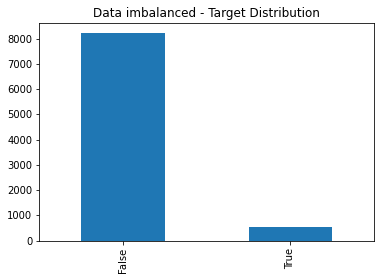

In [ ]:
df['EVENT_PRIMARY'].value_counts().plot(kind='bar', title='Data imbalanced - Target Distribution')

##Data Pre-Processing

1. **Clean the data**
  * *Missing Values* = drop record (from exploration we can see a loss of 0.05% of the data, not alot in the 'Event_Primary'=True class so we removed them).
2. **Apply transformations**
  * *Categorial Features* = Encoding with 'one hot' (from exploration we can see it will add only 4 more columns to a total of 33 features).
  * *Bool Features* = convert with Asymmetric Binary values, map values from {False,True} to {0,1}. (Features values are not equally important)
  * *Numerical Features* = Normalize with min max normalization to values in range [0,1] (so features scale will be in the same scale).

3. **Split the data**
  * train/test method with 20% of the data for test and 80% for train.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# drop rows with missing values
df = df.dropna()

# transform vars
sclr = MinMaxScaler()
for col in df.columns:
  if df.dtypes[col] == bool: #  Asymmetric Binarize bool vars
    df[col] = df[col].map({False: 0,True: 1})
  elif df.dtypes[col] == object: # encode categorical vars with one-hot
    one_hot = pd.get_dummies(df[col])
    df = df.drop(col,axis = 1)
    df = df.join(one_hot)
  else: # scale float/int vars with min-max normalization
    df[col] = sclr.fit_transform(df[[col]])

# Split for training and testing
X = df.drop('EVENT_PRIMARY',axis=1)
y = df['EVENT_PRIMARY']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22)

# **2.Train the models**

The main score of the CV will be 'F' because the data labels is not balanced (base on data exploration) and it will take into considiration both precision and recall. (we will also mesure accuracy, AUC , precision and recall).

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, classification_report

scorer = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': 'average_precision', 'Recall': 'recall_weighted', 'F': 'f1'}

We will use Grid Search Cross Validation in order to optimaize the hyper parameters of a given model and return the model with the best parameters.


In [ ]:
import time
from sklearn.model_selection import learning_curve, GridSearchCV

def get_best_model_grid_search(clf,parameters, X, y):
  grid_obj = GridSearchCV(clf, parameters, scoring=scorer, return_train_score=True, refit='F')
  start = round(time.time())
  grid_obj = grid_obj.fit(X, y)

  print("Search Time: " + str(round(time.time()) - start) + " sec")
  print("----")
  print("best params: " + str(grid_obj.best_params_))
  print("----")
  scores = pd.DataFrame(grid_obj.cv_results_)
  print("Best AUC score: " + str(grid_obj.best_score_))
  print("----")

  return grid_obj.best_estimator_, scores[[col for col in scores if col.startswith('param') or col.startswith('mean') or col.startswith('std')]]

## Linear Model - Logistic Regression

We will use Logistic Regression for our Linear Model.
This Dataset is clinical trial in the field of medicine, we can infer the most important feature for a decision base coefficients. we also tried other models
(MultinomialNB, SVC)

In [ ]:
from sklearn.linear_model import LogisticRegression

parameters = {'max_iter': [int(x) for x in np.linspace(start = 10000, stop = 12000, num = 2)],
              'C': [float(x) for x in np.linspace(start = 0.5, stop = 1.0, num = 2)],
              'class_weight' : [{0:1,1:7},{0:1,1:10},{0:1,1:12}]
            }

linear_clf, linear_cv_score = get_best_model_grid_search(LogisticRegression(),parameters,X,y)
linear_clf.fit(X_train,y_train)

print(classification_report(y_test, linear_clf.predict(X_test)))
print("----")
print('Train Accuracy:', linear_clf.score(X_train,y_train))
print('Test Accuracy:', linear_clf.score(X_test,y_test))

Search Time: 16 sec
----
best params: {'C': 1.0, 'class_weight': {0: 1, 1: 10}, 'max_iter': 10000}
----
Best AUC score: 0.20371708486954895
----
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      1549
           1       0.16      0.44      0.23       108

    accuracy                           0.81      1657
   macro avg       0.56      0.64      0.56      1657
weighted avg       0.90      0.81      0.85      1657

----
Train Accuracy: 0.8132548309178744
Test Accuracy: 0.8117079058539529


### All CV Scores:

In [ ]:
# cv scores
linear_cv_score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,params,mean_test_AUC,std_test_AUC,mean_train_AUC,std_train_AUC,mean_test_Accuracy,std_test_Accuracy,mean_train_Accuracy,std_train_Accuracy,mean_test_Precision,std_test_Precision,mean_train_Precision,std_train_Precision,mean_test_Recall,std_test_Recall,mean_train_Recall,std_train_Recall,mean_test_F,std_test_F,mean_train_F,std_train_F
0,0.193029,0.033882,0.017748,0.002493,0.5,"{0: 1, 1: 7}",10000,"{'C': 0.5, 'class_weight': {0: 1, 1: 7}, 'max_...",0.690167,0.008479,0.719267,0.002254,0.874411,0.005120,0.877732,0.000822,0.151170,0.019432,0.161915,0.004211,0.874411,0.005120,0.877732,0.000822,0.196276,0.023357,0.212066,0.002501
1,0.177105,0.017960,0.017551,0.001504,0.5,"{0: 1, 1: 7}",12000,"{'C': 0.5, 'class_weight': {0: 1, 1: 7}, 'max_...",0.690167,0.008479,0.719267,0.002254,0.874411,0.005120,0.877732,0.000822,0.151170,0.019432,0.161915,0.004211,0.874411,0.005120,0.877732,0.000822,0.196276,0.023357,0.212066,0.002501
2,0.214665,0.029399,0.017981,0.000672,0.5,"{0: 1, 1: 10}",10000,"{'C': 0.5, 'class_weight': {0: 1, 1: 10}, 'max...",0.690256,0.008634,0.719835,0.002285,0.809442,0.006451,0.813247,0.002103,0.151539,0.020166,0.161221,0.004692,0.809442,0.006451,0.813247,0.002103,0.200709,0.008748,0.218354,0.002253
3,0.206846,0.020912,0.016840,0.001172,0.5,"{0: 1, 1: 10}",12000,"{'C': 0.5, 'class_weight': {0: 1, 1: 10}, 'max...",0.690256,0.008634,0.719835,0.002285,0.809442,0.006451,0.813247,0.002103,0.151539,0.020166,0.161221,0.004692,0.809442,0.006451,0.813247,0.002103,0.200709,0.008748,0.218354,0.002253
4,0.221330,0.020643,0.019646,0.001975,0.5,"{0: 1, 1: 12}",10000,"{'C': 0.5, 'class_weight': {0: 1, 1: 12}, 'max...",0.690258,0.008874,0.720022,0.002260,0.760172,0.007571,0.764068,0.004115,0.151915,0.020948,0.160797,0.004585,0.760172,0.007571,0.764068,0.004115,0.197890,0.006593,0.212766,0.004124
5,0.207854,0.013357,0.015811,0.000837,0.5,"{0: 1, 1: 12}",12000,"{'C': 0.5, 'class_weight': {0: 1, 1: 12}, 'max...",0.690258,0.008874,0.720022,0.002260,0.760172,0.007571,0.764068,0.004115,0.151915,0.020948,0.160797,0.004585,0.760172,0.007571,0.764068,0.004115,0.197890,0.006593,0.212766,0.004124
6,0.218393,0.034781,0.015801,0.000405,1,"{0: 1, 1: 7}",10000,"{'C': 1.0, 'class_weight': {0: 1, 1: 7}, 'max_...",0.690313,0.009257,0.720348,0.002283,0.874411,0.005608,0.876857,0.001640,0.152185,0.021416,0.162844,0.004826,0.874411,0.005608,0.876857,0.001640,0.198756,0.023612,0.213942,0.004667
7,0.217983,0.027185,0.015796,0.000664,1,"{0: 1, 1: 7}",12000,"{'C': 1.0, 'class_weight': {0: 1, 1: 7}, 'max_...",0.690313,0.009257,0.720348,0.002283,0.874411,0.005608,0.876857,0.001640,0.152185,0.021416,0.162844,0.004826,0.874411,0.005608,0.876857,0.001640,0.198756,0.023612,0.213942,0.004667
8,0.251919,0.022146,0.017752,0.001972,1,"{0: 1, 1: 10}",10000,"{'C': 1.0, 'class_weight': {0: 1, 1: 10}, 'max...",0.690445,0.009374,0.720793,0.002249,0.810046,0.007139,0.813277,0.002673,0.152497,0.021745,0.161575,0.005054,0.810046,0.007139,0.813277,0.002673,0.203717,0.010608,0.219392,0.003309
9,0.256802,0.027939,0.016622,0.001782,1,"{0: 1, 1: 10}",12000,"{'C': 1.0, 'class_weight': {0: 1, 1: 10}, 'max...",0.690445,0.009374,0.720793,0.002249,0.810046,0.007139,0.813277,0.002673,0.152497,0.021745,0.161575,0.005054,0.810046,0.007139,0.813277,0.002673,0.203717,0.010608,0.219392,0.003309


## Ensemble Model - Balanced Random Forest

We will use Random Forest for our Ensemble Model.
This Dataset is clinical trial in the field of medicine, model desicion explanation is needed in this field and we can explain this model by looking at the estimators (Trees) and infer why the predicted class was selected; random forest is good for mitigating Class imbalance

In [ ]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

parameters = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 2)],
              'max_features': ['log2','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [20,30], 
              'min_samples_split': [5],
              'min_samples_leaf': [8,10]
             }

# parameters = {'max_depth': [30],
#              'n_estimators': [50, 100],
#              'class_weight': [{0:1, 1:10}, {0:1, 1:1}]}
              

ensemble_clf, ensemble_cv_score = get_best_model_grid_search(BalancedRandomForestClassifier(random_state=0),parameters,X,y)
ensemble_clf.fit(X_train,y_train)

print(classification_report(y_test,ensemble_clf.predict(X_test)))
print("----")
print('Train Accuracy:', ensemble_clf.score(X_train,y_train))
print('Test Accuracy:', ensemble_clf.score(X_test,y_test))

Search Time: 59 sec
----
best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 100}
----
Best AUC score: 0.1821423992004682
----
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1549
           1       0.12      0.70      0.21       108

    accuracy                           0.65      1657
   macro avg       0.55      0.68      0.49      1657
weighted avg       0.91      0.65      0.74      1657

----
Train Accuracy: 0.6657608695652174
Test Accuracy: 0.651780325890163


### All CV Scores:

In [ ]:
# cv scores
ensemble_cv_score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,mean_test_AUC,std_test_AUC,mean_train_AUC,std_train_AUC,mean_test_Accuracy,std_test_Accuracy,mean_train_Accuracy,std_train_Accuracy,mean_test_Precision,std_test_Precision,mean_train_Precision,std_train_Precision,mean_test_Recall,std_test_Recall,mean_train_Recall,std_train_Recall,mean_test_F,std_test_F,mean_train_F,std_train_F
0,0.351227,0.006267,0.044489,0.000961,entropy,20,log2,8,5,50,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.690447,0.015729,0.854047,0.002787,0.639416,0.006242,0.672624,0.004721,0.153630,0.006120,0.316592,0.004746,0.639416,0.006242,0.672624,0.004721,0.179621,0.010832,0.249581,0.004291
1,0.680150,0.012532,0.079823,0.006294,entropy,20,log2,8,5,100,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.692707,0.013342,0.857934,0.002761,0.643159,0.008716,0.674043,0.005090,0.159076,0.007018,0.327378,0.005424,0.643159,0.008716,0.674043,0.005090,0.182142,0.004382,0.250402,0.003725
2,0.336311,0.015641,0.045186,0.003007,entropy,20,log2,10,5,50,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.686690,0.017806,0.831192,0.003153,0.646056,0.012450,0.671054,0.007839,0.142975,0.014485,0.278403,0.009521,0.646056,0.012450,0.671054,0.007839,0.180571,0.007892,0.240874,0.004034
3,0.707705,0.022123,0.073443,0.004942,entropy,20,log2,10,5,100,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.691347,0.016834,0.834673,0.003466,0.641709,0.009952,0.669846,0.004884,0.157109,0.019731,0.288762,0.009701,0.641709,0.009952,0.669846,0.004884,0.180454,0.012181,0.240688,0.002786
4,0.366126,0.022176,0.047879,0.004207,entropy,30,log2,8,5,50,"{'criterion': 'entropy', 'max_depth': 30, 'max...",0.690447,0.015729,0.854047,0.002787,0.639416,0.006242,0.672624,0.004721,0.153630,0.006120,0.316592,0.004746,0.639416,0.006242,0.672624,0.004721,0.179621,0.010832,0.249581,0.004291
5,0.742430,0.040149,0.080807,0.008914,entropy,30,log2,8,5,100,"{'criterion': 'entropy', 'max_depth': 30, 'max...",0.692707,0.013342,0.857934,0.002761,0.643159,0.008716,0.674043,0.005090,0.159076,0.007018,0.327378,0.005424,0.643159,0.008716,0.674043,0.005090,0.182142,0.004382,0.250402,0.003725
6,0.346670,0.008839,0.041258,0.002321,entropy,30,log2,10,5,50,"{'criterion': 'entropy', 'max_depth': 30, 'max...",0.686690,0.017806,0.831192,0.003153,0.646056,0.012450,0.671054,0.007839,0.142975,0.014485,0.278403,0.009521,0.646056,0.012450,0.671054,0.007839,0.180571,0.007892,0.240874,0.004034
7,0.745610,0.057184,0.080424,0.007662,entropy,30,log2,10,5,100,"{'criterion': 'entropy', 'max_depth': 30, 'max...",0.691347,0.016834,0.834673,0.003466,0.641709,0.009952,0.669846,0.004884,0.157109,0.019731,0.288762,0.009701,0.641709,0.009952,0.669846,0.004884,0.180454,0.012181,0.240688,0.002786
8,0.352796,0.027701,0.048704,0.004413,gini,20,log2,8,5,50,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.691439,0.015937,0.850417,0.003120,0.636758,0.010327,0.669213,0.005817,0.152602,0.015753,0.309846,0.012204,0.636758,0.010327,0.669213,0.005817,0.178421,0.007765,0.246318,0.004848
9,0.686473,0.041637,0.080419,0.013214,gini,20,log2,8,5,100,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.694031,0.012371,0.855050,0.002388,0.641467,0.008946,0.671628,0.004766,0.161200,0.018015,0.321278,0.011696,0.641467,0.008946,0.671628,0.004766,0.180086,0.005135,0.248701,0.003080


## DL Model - NN

We used Neural Network by sklearn for the deep learning modellogistic - so we can use the interfaces that it provides like all the other models (we also tried Keras), the network is built with 2 hidden layers, each layer is half the size of its previous one, all hyper parameters were tested in gridsearchCV (long run time so we excluded it from the code).

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters = {'hidden_layer_sizes': [(int(len(X_train.columns)/2),int(len(X_train.columns)/4),)],
              'activation': ['logistic'],
              'batch_size': [7], 
              'validation_fraction': [0.2],
              'max_iter': [500]
             }

dl_clf, dl_cv_score = get_best_model_grid_search(MLPClassifier(),parameters,X,y)
dl_clf.fit(X_train,y_train)

print(classification_report(y_test,dl_clf.predict(X_test)))
print("----")
print('Train Accuracy:', dl_clf.score(X_train,y_train))
print('Test Accuracy:', dl_clf.score(X_test,y_test))

Search Time: 725 sec
----
best params: {'activation': 'logistic', 'batch_size': 7, 'hidden_layer_sizes': (16, 8), 'max_iter': 500, 'validation_fraction': 0.2}
----
Best AUC score: 0.01818181818181818
----
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1549
           1       0.00      0.00      0.00       108

    accuracy                           0.93      1657
   macro avg       0.47      0.50      0.48      1657
weighted avg       0.87      0.93      0.90      1657

----
Train Accuracy: 0.938858695652174
Test Accuracy: 0.9348219674109837


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### All CV Scores:

In [ ]:
# cv scores
dl_cv_score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_hidden_layer_sizes,param_max_iter,param_validation_fraction,params,mean_test_AUC,std_test_AUC,mean_train_AUC,std_train_AUC,mean_test_Accuracy,std_test_Accuracy,mean_train_Accuracy,std_train_Accuracy,mean_test_Precision,std_test_Precision,mean_train_Precision,std_train_Precision,mean_test_Recall,std_test_Recall,mean_train_Recall,std_train_Recall,mean_test_F,std_test_F,mean_train_F,std_train_F
0,108.725087,25.684728,0.020735,0.003136,logistic,7,"(16, 8)",500,0.2,"{'activation': 'logistic', 'batch_size': 7, 'h...",0.660517,0.026426,0.792546,0.017524,0.937085,0.001462,0.939319,0.000417,0.124038,0.027035,0.25481,0.023505,0.937085,0.001462,0.939319,0.000417,0.018182,0.036364,0.05776,0.02163


# **3.Compare results**

To compare the models we used 3 graphs (and metrics):
1. **ROC curve**
2. **Precision Recall Curve**
3. **K-fold F score**

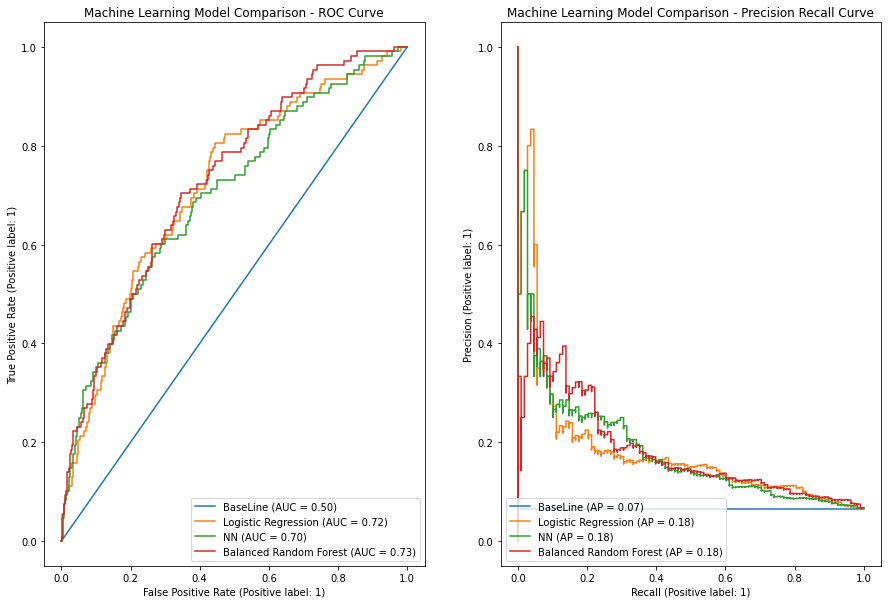

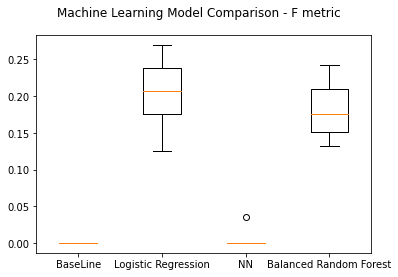

BaseLine| Mean=0.000000 STD=0.000000 Time elapsed=0(sec)
Logistic Regression| Mean=0.205545 STD=0.041366 Time elapsed=2(sec)
NN| Mean=0.003571 STD=0.010714 Time elapsed=866(sec)
Balanced Random Forest| Mean=0.182493 STD=0.036020 Time elapsed=8(sec)


In [ ]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

outcome = []
models = []
names = []
acc_msg = []

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train,y_train)

models.append(('BaseLine', baseline_model)) # generate a no skill prediction (majority class)
models.append(('Logistic Regression', linear_clf))
models.append(('NN', dl_clf))
models.append(('Balanced Random Forest', ensemble_clf))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax1.set_title('Machine Learning Model Comparison - ROC Curve')
ax2.set_title('Machine Learning Model Comparison - Precision Recall Curve')

for model_name, model in models:
    plot_roc_curve(model,X_test,y_test,name=model_name, ax=ax1)
    plot_precision_recall_curve(model,X_test,y_test,name=model_name,ax=ax2)
    k_fold_validation = model_selection.KFold(n_splits=10)
    start = round(time.time())
    results = model_selection.cross_val_score(model, X, y, cv=k_fold_validation, scoring='f1')
    output_message = "%s| Mean=%f STD=%f Time elapsed=%i(sec)" % (model_name, results.mean(), results.std(), round(time.time()) - start)
    outcome.append(results)
    names.append(model_name)
    acc_msg.append(output_message)

plt.show()

fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison - F metric')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(names)
plt.show()

for msg in acc_msg:
  print(msg)

## Conclusions:

Qualitative perspective:<br>
We lack knowledge in the medical domain and therefore we can't call a concrete conclusion.
We provide all the graphs we think that might help an expert in the medicine domain to get the right decision.

Quantitative perspective:<br>
As we can see from the graphs above, the **Logistic Regression** got the highest scores, but the **Balanced Random Forest** got a very close scores to the Logistic Regression.<br>
NN model's scores are also high but it has low score if we look only on the target class value = 1 ('EVENT_PRIMARY' = True) so its less relevant.

Based on the following:
1. decision tree model has higher interpretability than regression model.
2. the scores of both models were pretty much the same.
3. Our problem is from the medicine domain where explaintation of the decisions is very important.

our advice is to use the **Balanced Random Forest** model prediction as the main decision support tool.




In [ ]:
print()
print("===========================================================================")
print()
print("Total Run Time: " + str(round(time.time()) - start_run) + " sec")



Total Run Time: 1762.2051951885223 sec
